In [0]:
import cv2
import os 
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Cropping2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

# Установим параметры изображения 
IMG_WIDTH = 320
IMG_HEIGHT = 240
IMG_CHANNELS = 3

MASK_WIDTH = 320
MASK_HEIGHT = 240
MASK_CHANNELS = 17
# Определим пути к изображениям и их маскам
TRAIN_PATH = '/content/gdrive/My Drive/Colab Notebooks/DMIA_lego_train_images/train_images/'
TEST_PATH = '/content/gdrive/My Drive/Colab Notebooks/DMIA_lego_test_images/test_images/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Имя сабмита по умолчанию
sub_file_name = 'submission.csv'

# Сделаем результаты воспроизводимыми
seed = 42
# random.seed = seed
# np.random.seed = seed

batch_size = 24

Using TensorFlow backend.


In [0]:
# Установим размеры и стиль графиков 
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)


In [0]:
# Прикрутим Google drive
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
!ls 'gdrive/My Drive/Colab Notebooks/DMIA_lego_train_images'

__MACOSX  submission.csv  train_images


In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [0]:
print(len(train_ids), train_ids)
print(len(test_ids), test_ids)

291 ['050b1cd2-bc21-475c-a5ca-05755d607521', '544b1e26-92fd-4f3c-a3fa-3d183bf5cd41', 'cd11d07f-f329-4384-9aab-c03f50669ac3', 'c9b7391e-9f39-4443-9740-56cc3a463894', 'c8624c98-fc1a-4d95-a25c-36566742ce3e', 'e6af4aea-5713-40b0-85f7-134dc2d83f18', '067f10e3-cfa3-403a-8832-9165e67304c0', '46ce1768-f3ef-440a-b93b-52c0576e8add', 'bc919654-54e1-4d74-a4de-a2303358b790', 'a28d8211-1eb3-434c-b466-4d98fc21d638', 'aee3a900-94b9-432a-b38e-ca959bb690de', '96354e11-d516-4063-8ead-cb100b81a493', '18127a95-d025-4563-a897-b9bcbe077854', 'ba71262d-44bd-42d8-be2f-88e82dcc9c9c', '07649f07-3865-47f0-80e5-6bf3d73c968e', 'db5ad3c9-476c-4ae4-9a0d-ffbdca0bd6a0', 'e5525e32-0423-4c9b-828d-2e3645fc2737', '6f945389-c31a-4f4c-8e03-e8c22aa2f5ef', '33ec7d43-1bde-429b-93a3-4016742369ce', '4c7c63d8-3b44-43a0-93f0-7a512e5b54fd', '0ec7621b-9bc0-4500-97f9-a84e12aa1f71', '8a7b9527-e9cd-4870-9724-eb05c2904131', '57a28ae2-ba43-4542-a6a6-ceb186e44ef6', 'e40bce7b-8a84-4124-a840-46d8698ade9c', '293f772e-8608-4105-8cb6-7283c5cb61

## Вспомогательные функции

In [0]:
def hex_2_rgb(hex):
  ''' Переводит из 16тиричной системы исчисления в 3х цветный '''
  return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

In [0]:
# Исходные цвета в 16тиричной системе исчисления

classes_pallete = ['2F8E3C','87CF6E','AC75D1','B4A83C'
                  ,'3BB0A4','DFDC9F','3D47B8','862D6D'
                  ,'88CED7','CF716E','82622B','503399'
                  ,'DDC9ED','C1448F','5381C6','FFDF64',
                  '14DB8F']

In [0]:
# Переведенные цвета в RGB, где 1-й элемент массива это напряжение для красного цвета, 
# 2-й зеленого, 3-й голоубого.
class_color = [hex_2_rgb(color) for color in classes_pallete]
class_color

[(47, 142, 60),
 (135, 207, 110),
 (172, 117, 209),
 (180, 168, 60),
 (59, 176, 164),
 (223, 220, 159),
 (61, 71, 184),
 (134, 45, 109),
 (136, 206, 215),
 (207, 113, 110),
 (130, 98, 43),
 (80, 51, 153),
 (221, 201, 237),
 (193, 68, 143),
 (83, 129, 198),
 (255, 223, 100),
 (20, 219, 143)]

In [0]:
def get_masked_image(image, mask):
    out = image.copy()
    for i in range(3):
        out[:,:,i][mask[:,:,0]==20] = 0 
    return out

In [0]:
def get_color(i):
  '''Возвращает вектор цветов i-го номера, обращается к глобальному имени!'''
  return class_color[i]

get_color_v = np.vectorize(get_color)
def get_mask_from_multiclass(mask, classes = 17):
  
  '''Возвращает самую большую маску из мултиклассовой маски'''
  cl = np.argmax(mask,axis=2)
  new_mask = np.transpose(np.array(get_color_v(cl)),axes=(1,2,0)).astype(np.uint8)
  return new_mask

In [0]:
def show_ix(ix):
    image = resize(X_train[ix], (480, 640), mode='constant', preserve_range=True).astype(np.float32)
    mask = resize(get_mask_from_multiclass(Y_train[ix]), (480, 640), mode='constant', preserve_range=True)
    mask_pred = resize(get_mask_from_multiclass(preds_train[ix]), (480, 640), mode='constant', preserve_range=True).astype(np.float32)

    print(mask.shape)
    masked = get_masked_image(image,mask_pred)
    
    pos, axarr = plt.subplots(2, 2)
    
    axarr[0, 0].set_title('image')
    axarr[0, 0].imshow(image.astype(np.uint8))
    axarr[0, 1].set_title('image mask')
    axarr[0, 1].imshow(mask.astype(np.uint8))
    axarr[1, 0].set_title('image masked by pred')
    axarr[1, 0].imshow(masked.astype(np.uint8))
    axarr[1, 1].set_title('predicted mask')
    axarr[1, 1].imshow(mask_pred.astype(np.uint8))

## Предобработка данных

Прежде чем загружать данные проверь

In [0]:
del X_train_, Y_train_, X_test_, Y_test_

NameError: ignored

In [0]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), MASK_HEIGHT, MASK_WIDTH, MASK_CHANNELS), dtype=np.bool)

train_image_id = []
test_image_id = []

print('Предобработка тренировочных данных ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    train_image_id.append(id_)
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        
        object_class = int(mask_file[-6:-4])
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (MASK_HEIGHT, MASK_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        Y_train[n][:,:,object_class] = np.squeeze(mask_)

    Y_train[n][:,:,16] = np.logical_not(np.max(Y_train[n][:,:,:16], axis=2))

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Предобработка тестовых данных ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    test_image_id.append(id_)
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

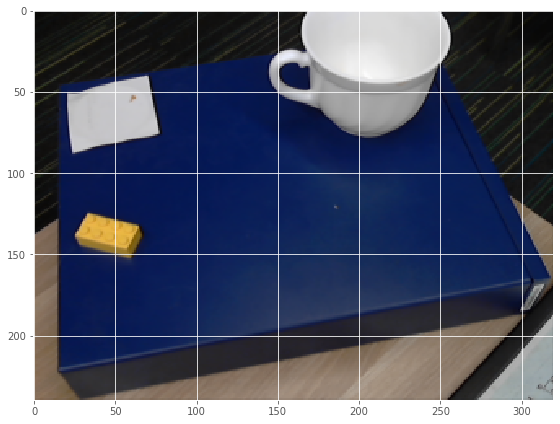

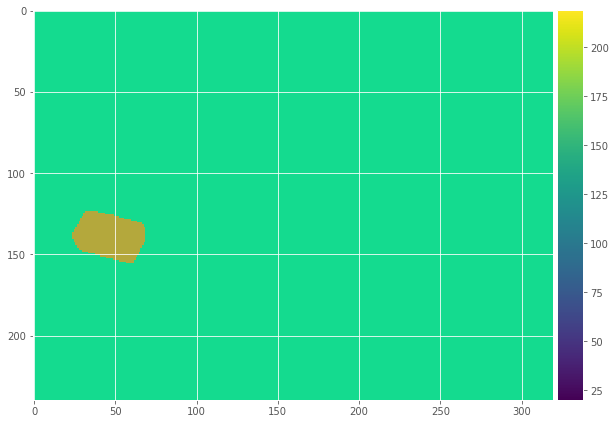

In [0]:
picture_index = random.randint(0, len(train_ids))
imshow(X_train[picture_index])
plt.show()
imshow(get_mask_from_multiclass(Y_train[picture_index]))
plt.show()

## Метрика для оценки качества модели

In [0]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 17)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
from sklearn.model_selection import train_test_split
X_train_ ,X_test_, Y_train_, Y_test_ = train_test_split(X_train, Y_train, test_size=0.01, random_state=42)
X_train.shape, X_train_.shape

((291, 240, 320, 3), (288, 240, 320, 3))

In [0]:
X_train_, Y_train_ = X_train, Y_train
del X_train, Y_train

In [0]:
from albumentations.augmentations import transforms


In [0]:
X_train_blur, Y_train_blur = [], []

augmentation = transforms.MedianBlur(blur_limit=3, always_apply=True, p=1)
for i in range(len(X_train_)):
  data = {"image": X_train_[i], 'mask': Y_train_[i]}
  augmented = augmentation(**data)
  X_train_blur.append(augmented['image'])
  Y_train_blur.append(augmented['mask'])
  # imshow(image)

X_train_blur, Y_train_blur = np.array(X_train_blur), np.array(Y_train_blur)

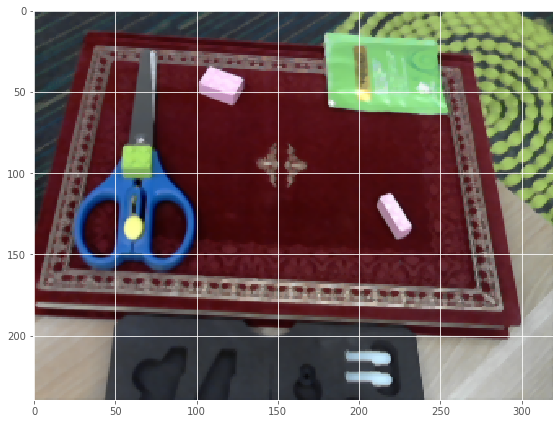

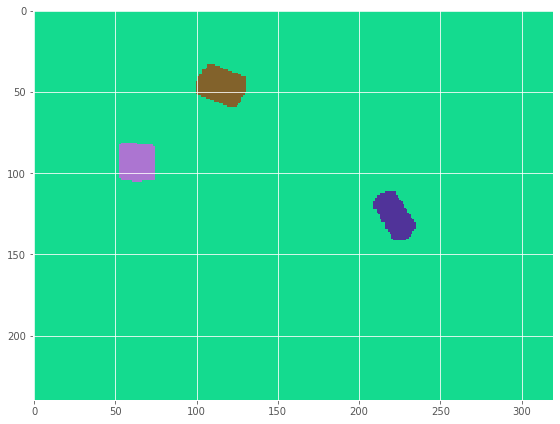

In [0]:
picture_index = random.randint(0, len(X_train_))
imshow(X_train_blur[picture_index])
plt.show()
imshow(get_mask_from_multiclass(Y_train_blur[picture_index]))
plt.show()

In [0]:
X_train_norm, Y_train_norm = [], []

augmentation = transforms.CLAHE(12, always_apply=True, p=1.0)
for i in range(len(X_train_)):
  data = {"image": X_train_[i], 'mask': Y_train_[i]}
  augmented = augmentation(**data)
  X_train_norm.append(augmented['image'])
  Y_train_norm.append(augmented['mask'])
  # imshow(image)

X_train_norm, Y_train_norm = np.array(X_train_norm ), np.array(Y_train_norm)

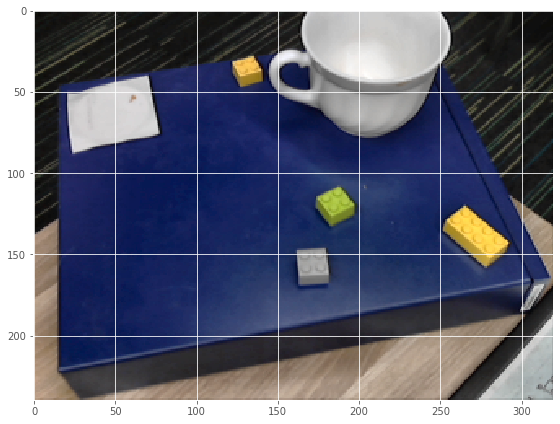

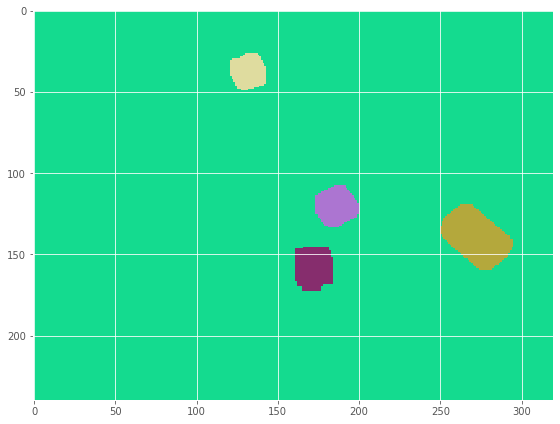

In [0]:
# picture_index = random.randint(0, len(X_train_))
imshow(X_train_norm[picture_index])
plt.show()
imshow(get_mask_from_multiclass(Y_train_norm[picture_index]))
plt.show()

In [0]:
# X_train_ = np.concatenate((X_train_, X_train_blur, X_train_norm))
# Y_train_ = np.concatenate((Y_train_, Y_train_blur, Y_train_norm))

X_train_ = np.concatenate((X_train_, X_train_norm))
Y_train_ = np.concatenate((Y_train_, Y_train_norm))

In [0]:
del X_train_blur, Y_train_blur, X_train_norm, Y_train_norm

NameError: ignored

In [0]:
X_train_.shape

(2328, 240, 320, 3)

In [0]:
from keras.preprocessing.image import ImageDataGenerator


# we create two instances with the same arguments
train_data_gen_args = dict(rescale=1./255,
#                            zca_whitening=True,
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
                     horizontal_flip=True,
                     vertical_flip=True,
#                      channel_shift_range=10,
#                      shear_range=0.1,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
#                      zoom_range=0.1,
                     )

test_data_gen_args = dict(rescale=1./255)



In [0]:
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

test_image_datagen = ImageDataGenerator(**test_data_gen_args)
test_mask_datagen = ImageDataGenerator(**test_data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods

train_image_datagen.fit(X_train_, augment=True, seed=seed)
train_mask_datagen.fit(Y_train_, augment=True, seed=seed)

test_image_datagen.fit(X_test_, augment=True, seed=seed)
test_mask_datagen.fit(Y_test_, augment=True, seed=seed)

train_image_generator = train_image_datagen.flow(X_train_, batch_size=batch_size, seed=seed)
train_mask_generator = train_mask_datagen.flow(Y_train_, batch_size=batch_size, seed=seed)

test_image_generator = test_image_datagen.flow(X_test_, batch_size=batch_size, seed=seed)
test_mask_generator = test_mask_datagen.flow(Y_test_, batch_size=batch_size, seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(train_image_generator, train_mask_generator)

test_generator = zip(test_image_generator, test_mask_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (406, 240, 320, 17) (17 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (88, 240, 320, 17) (17 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3

In [0]:
X_batch_, Y_batch_ = next(train_generator)
X_batch, Y_batch = next(test_generator)

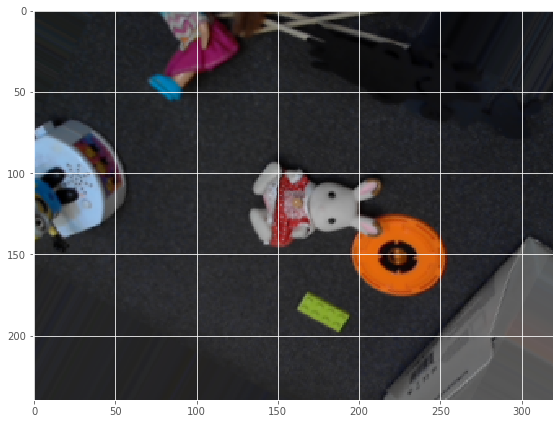

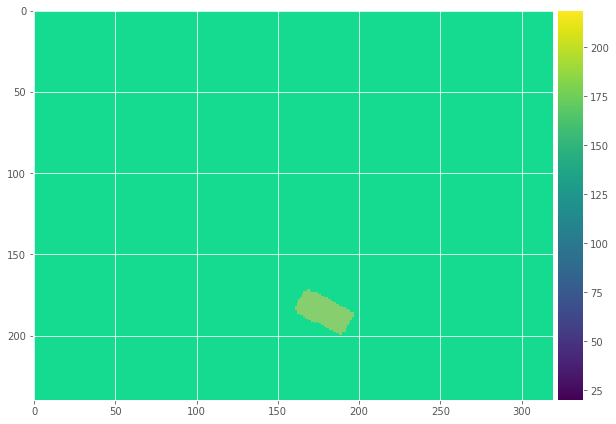

In [0]:
picture_index = random.randint(0, len(X_batch_))
imshow(X_batch_[picture_index])
plt.show()
imshow(get_mask_from_multiclass(Y_batch_[picture_index]))
plt.show()

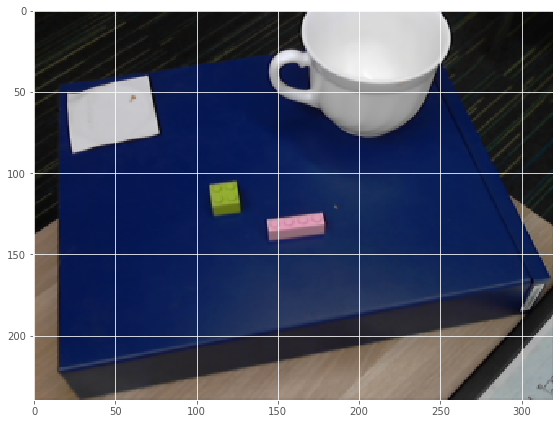

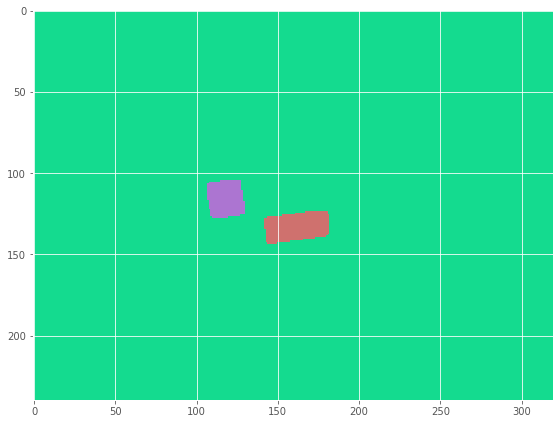

In [0]:
picture_index = random.randint(0, len(X_batch))
imshow(X_batch[picture_index])
plt.show()
imshow(get_mask_from_multiclass(Y_batch[picture_index]))
plt.show()

## Попробуем определять границы с помощью OpenCV

In [0]:
# hsv_min = np.array((0, 54, 5), np.uint8)
# hsv_max = np.array((187, 255, 253), np.uint8)

# if __name__ == '__main__':
#     img = X_train[45].copy()
    
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.GaussianBlur(gray, (3, 3), 0)
#     edged = cv2.Canny(gray, 100, 500)
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
#     closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
#     cnts = cv2.findContours(closed.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
#     total = 0
#     for c in cnts:
#         # аппроксимируем (сглаживаем) контур
#         peri = cv2.arcLength(c, True)
#         approx = cv2.approxPolyDP(c, 0.01 * peri, True)
#         rect = cv2.minAreaRect(c) # пытаемся вписать прямоугольник
#         box = cv2.boxPoints(rect) # поиск четырех вершин прямоугольника
#         box = np.int0(box)
        
#         area = int(rect[1][0]*rect[1][1]) # вычисление площади
#         if area < 1100 and area > 200:
#         # если у контура 4 вершины, предполагаем, что это книга
#           cv2.drawContours(img,[box],0,(255,0,0),2)# рисуем прямоугольник

#           if len(approx) in [4, 5, 6, 7, 8]:
#               cv2.drawContours(img, [approx], -1, (0, 255, 0), 4)
              
# #             total += 1

# #     hsv = cv2.cvtColor( img, cv.COLOR_BGR2HSV ) # меняем цветовую модель с BGR на HSV
# #     thresh = cv2.inRange( hsv, hsv_min, hsv_max ) # применяем цветовой фильтр
# #     _, contours0, hierarchy = cv.findContours( thresh.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    
#     # перебираем все найденные контуры в цикле
# #     for cnt in contours0:
# #         rect = cv2.minAreaRect(cnt) # пытаемся вписать прямоугольник
# #         box = cv2.boxPoints(rect) # поиск четырех вершин прямоугольника
# #         box = np.int0(box) # округление координат
# #         area = int(rect[1][0]*rect[1][1]) # вычисление площади
# #         if area > 200 and area < 400:
# #           cv.drawContours(img,[box],0,(255,0,0),2)# рисуем прямоугольник

#     plt.imshow(img) # вывод обработанного кадра в окно
#     plt.show()
    
#     plt.imshow(img_gaus)
#     plt.show()
    
#     plt.imshow(closed)
#     plt.show()
    
#     plt.imshow(img)
    
#     cv2.waitKey()
#     cv2.destroyAllWindows()

Сдадимся

## Построение сети

In [0]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = Lambda(lambda x: x / 255) (inputs)
s = Lambda(lambda x: x) (inputs) # с аугментацией
# s = BatchNormalization() (s)


In [0]:
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = BatchNormalization() (c1)
c1 = Dropout(0.2) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)

c1 = BatchNormalization() (c1)
p1 = MaxPooling2D((2, 2)) (c1)
# c1 = Cropping2D(((184, 184), (184, 184))) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization() (c2)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)

c2 = BatchNormalization() (c2)
p2 = MaxPooling2D((2, 2)) (c2)
# c2 = Cropping2D(((88, 88), (88, 88))) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization() (c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)

c3 = BatchNormalization() (c3)
p3 = MaxPooling2D((2, 2)) (c3)
# c3 = Cropping2D(((40, 40), (40, 40))) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization() (c4)
c4 = Dropout(0.2) (c4)
# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal') (c4)

c4 = BatchNormalization() (c4)
p4 = MaxPooling2D((2, 2)) (c4)
# c4 = Cropping2D(((16, 16), (16, 16))) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization() (c5)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

c5 = BatchNormalization() (c5)
p5 = MaxPooling2D((2, 2)) (c5)
# c5 = Cropping2D(((4, 4), (4, 4))) (c5)


c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p5)
c6 = BatchNormalization() (c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

c6 = BatchNormalization() (c6)


In [0]:
u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c5])
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization() (c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization() (c7)

u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c4])
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization() (c8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization() (c8)

u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c3])
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization() (c9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization() (c9)

u10 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c2])
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u10)
c10 = BatchNormalization() (c10)
c10 = Dropout(0.2) (c10)
c10 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c10)
c10 = BatchNormalization() (c10)

u11 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c10)
u11 = concatenate([u11, c1])
c11 = Conv2D(16, (2, 2), activation='elu', kernel_initializer='he_normal', padding='same') (u11)
c11 = BatchNormalization() (c11)
c11 = Dropout(0.2) (c11)
c11 = Conv2D(16, (2, 2), activation='elu', kernel_initializer='he_normal', padding='same') (c11)

ValueError: ignored

In [0]:
outputs = Conv2D(17, (1, 1), activation='sigmoid') (c11)

In [0]:
def balanced_cross_entropy(beta):
  def convert_to_logits(y_pred):
      # see https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/backend.py#L3525
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

      return tf.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    pos_weight = beta / (1 - beta)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss * (1 - beta))

  return loss

In [0]:
def focal_loss(alpha=0.25, gamma=2):
  def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
    weight_a = alpha * (1 - y_pred) ** gamma * targets
    weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
    
    return (tf.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b 

  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.log(y_pred / (1 - y_pred))

    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

  return loss

In [0]:
from keras.losses import binary_crossentropy

def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

#     return balanced_cross_entropy(tf.reduce_sum(1 - y_true) / \
#                                   (batch_size * IMG_HEIGHT * IMG_WIDTH))(y_true, y_pred) + \
#   dice_loss(y_true, y_pred) #+ focal_loss()(y_true, y_pred)
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred) #+ focal_loss()(y_true, y_pred)


In [0]:
class_weights = {0: 183158,
 1: 168860,
 2: 83578,
 3: 142484,
 4: 87166,
 5: 98856,
 6: 148134,
 7: 78138,
 8: 99004,
 9: 83520,
 10: 138174,
 11: 81878,
 12: 56824,
 13: 128040,
 14: 75506,
 15: 67820,
 16: 65325260}

sum_val = sum(class_weights.values())

for i in class_weights.keys():
  class_weights[i] = 1 - class_weights[i]/sum_val

class_weights

{0: 0.9972681903875525,
 1: 0.9974814456853761,
 2: 0.9987534304600992,
 3: 0.9978748448835434,
 4: 0.9986999152825506,
 5: 0.998525558419244,
 6: 0.9977905748854524,
 7: 0.9988345682989691,
 8: 0.9985233509927454,
 9: 0.998754295532646,
 10: 0.997939128722795,
 11: 0.9987787860347461,
 12: 0.9991524675448644,
 13: 0.9980902777777778,
 14: 0.9988738246945399,
 15: 0.9989884617220313,
 16: 0.02567087867506679}

In [0]:
class_loss = np.array(list(class_weights.values())) * 10

In [0]:
class_loss

array([9.9726819 , 9.97481446, 9.9875343 , 9.97874845, 9.98699915,
       9.98525558, 9.97790575, 9.98834568, 9.98523351, 9.98754296,
       9.97939129, 9.98778786, 9.99152468, 9.98090278, 9.98873825,
       9.98988462, 0.25670879])

In [0]:
model = Model(inputs=[inputs], outputs=[outputs])

NameError: ignored

In [0]:
path_to_save = 'gdrive/My Drive/Colab Notebooks/Callbacks/Original_320x240_Adam_loss_+6(-norm)_origmask+norm+orig.h5'
model = load_model(path_to_save, custom_objects={'mean_iou': mean_iou, 'loss' : loss})

# model.compile(optimizer='adam', loss=loss, metrics=[mean_iou])
model.compile(optimizer='adam', loss=loss, 
              metrics=[mean_iou])#, loss_weights=[class_loss])












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.




In [0]:
tmp = model.predict(X_test_[0:2])
imshow(X_test_[0])
plt.show()
imshow(get_mask_from_multiclass(tmp[0]))
plt.show()

NameError: ignored

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 320, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 320, 16) 64          conv2d_2[0][0]                   
____________________________________________________________________________________________

In [0]:
X_train_norm, Y_train_norm = [], []

augmentation = transforms.VerticalFlip(p=0.5)
for i in range(len(X_train_)):
  data = {"image": X_train_[i], 'mask': Y_train_[i]}
  augmented = augmentation(**data)
  X_train_norm.append(augmented['image'])
  Y_train_norm.append(augmented['mask'])
  # imshow(image)

X_train_, Y_train_ = np.array(X_train_norm ), np.array(Y_train_norm)

In [0]:
X_train_norm, Y_train_norm = [], []

augmentation = transforms.HorizontalFlip(p=0.5)
for i in range(len(X_train_)):
  data = {"image": X_train_[i], 'mask': Y_train_[i]}
  augmented = augmentation(**data)
  X_train_norm.append(augmented['image'])
  Y_train_norm.append(augmented['mask'])
  # imshow(image)

X_train_, Y_train_ = np.array(X_train_norm ), np.array(Y_train_norm)

In [0]:
X_train_.shape

(2619, 240, 320, 3)

In [0]:
del X_train_norm, Y_train_norm

In [0]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)
import numpy as np

def strong_aug(p=0.5):
    return Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)


augmentation = strong_aug(p=0.5)
data = {"image": X_train_, "mask": Y_train_}
augmented = augmentation(**data)
X_train_, Y_train_ = augmented["image"], augmented["mask"]

In [0]:
X_train_.shape

(2328, 240, 320, 3)

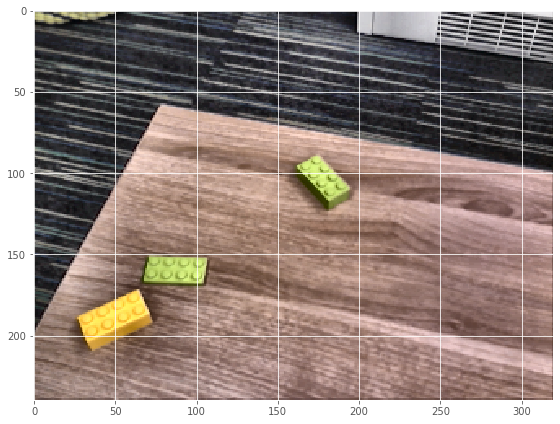

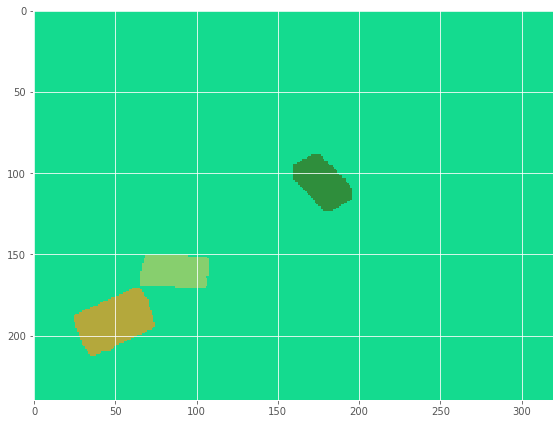

In [0]:
picture_index = random.randint(0, len(X_train_))
imshow(X_train_[picture_index])
plt.show()
imshow(get_mask_from_multiclass(Y_train_[picture_index]))
plt.show()

In [0]:
from keras.callbacks import ReduceLROnPlateau, TensorBoard


path_to_save = 'gdrive/My Drive/Colab Notebooks/Callbacks/model_segmentation_homework-1.hdf5'

# earlystopper = EarlyStopping(patience=5, verbose=0)
mc = ModelCheckpoint(path_to_save, monitor='val_loss',
                     mode='min', save_best_only=True, verbose=1)

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5,
#                                             min_lr=0, factor=0.2, verbose=1)

# # tb = TensorBoard(log_dir='logs', write_graph=True)

# es = EarlyStopping(patience=15, verbose=1)
callbacks = [ mc]

In [0]:
# result = model.fit_generator(generator=train_generator, 
#                              steps_per_epoch= len(X_train_) // batch_size,
#                              epochs=1, 
#                              callbacks=callbacks, 
# #                              validation_data=(X_test_, Y_test_),
#                              validation_data=test_generator,
#                              validation_steps=len(X_test_) // batch_size)
# #                              class_weight=class_loss)

path_to_save = 'gdrive/My Drive/Colab Notebooks/Callbacks/model_segmentation_homework-1.hdf5'

# earlystopper = EarlyStopping(patience=5, verbose=0)
# checkpointer = ModelCheckpoint(path_to_save,
#                                verbose=1, save_best_only=True)
results = model.fit(X_train_, Y_train_, validation_split=0.1, batch_size=24,
                    epochs=1,
                    callbacks=callbacks)

Train on 2095 samples, validate on 233 samples
Epoch 1/1
2095/2095 [==============================] - 104s 50ms/step - loss: 0.0035 - mean_iou: 0.9973 - val_loss: 0.0125 - val_mean_iou: 0.9973

Epoch 00001: val_loss did not improve from 0.00573


In [0]:
# Дообучим с аугментацией
# result = model.fit_generator(generator=train_generator, 
#                              steps_per_epoch=232 // batch_size,
#                              epochs=200, 
#                              callbacks=callbacks, 
# #                              validation_data=(X_test_, Y_test_),
#                              validation_data=test_generator,
#                              validation_steps=58 // batch_size,
#                              class_weight=class_count)

## Построим пару графиков

In [0]:
history = result

In [0]:
def plotter_train_test(history, name1, name2):
  plt.plot(history.history[str(name1)])
  plt.plot(history.history[str(name2)])
  plt.title('model'+str(name1))
  plt.ylabel(str(name1))
  plt.xlabel('epoch')
  plt.legend(['train', 'test'])
  plt.show()

In [0]:
plotter_train_test(history, 'loss', 'val_loss')

In [0]:
plotter_train_test(history, 'mean_iou', 'val_mean_iou')

## Предсказание модели

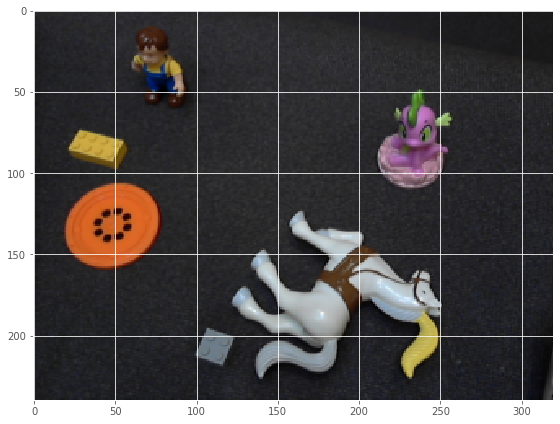

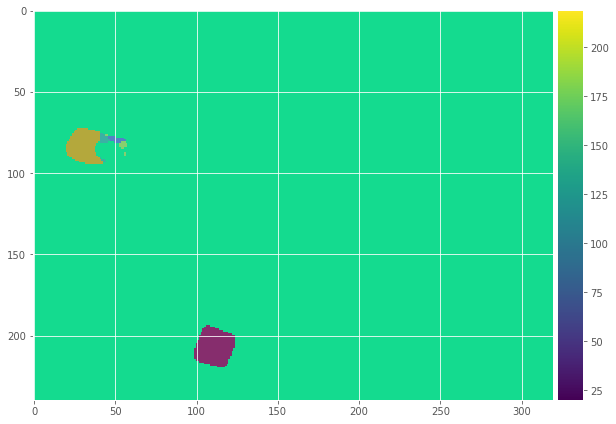

In [0]:

imshow(X_test[0])
plt.show()
imshow(get_mask_from_multiclass(tmp[0]))
plt.show()

In [0]:
path_to_save = 'gdrive/My Drive/Colab Notebooks/Callbacks/model_segmentation_homework-1.hdf5'
# model = load_model(path_to_save, custom_objects={'mean_iou': mean_iou})
model = load_model(path_to_save, custom_objects={'mean_iou': mean_iou, 'loss' : loss})
# preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


# preds_train_t = (preds_train > 0.5).astype(np.uint8)
# preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


127/127 [==============================] - 6s 48ms/step


In [0]:
picture_index = random.randint(0, len(preds_train_t))
show_ix(picture_index)
# plt.imshow(preds_train_t[picture_index])

NameError: ignored

## Подготовим сабмиты

In [0]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

        
def bool_to_rles(x):
    lab_img = label(x)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)    
           
def join_nums(x):
    s = ''
    for z in x:
        s = s + ' '.join(str(y) for y in z) + ' '
    return s[:-1]

def rle2mask(mask_rle, shape):
    """
    mask_rle: run-length as string formated (start length)ы
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros_like(shape)
      
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def rle_bool(img):
    flat_img = img.ravel(order='F').astype(np.uint8)
    flat_img = np.insert(flat_img, [0, len(flat_img)], [0, 0])

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 1
    ends_ix = np.where(ends)[0] + 1
    lengths = ends_ix - starts_ix

    encoding = ''
    for idx in range(len(starts_ix)):
        encoding += '%d %d ' % (starts_ix[idx], lengths[idx])
    return encoding.rstrip()

In [0]:
def make_submission(predictions, file_name = 'gdrive/My Drive/Colab Notebooks/DMIA_lego_train_images/submission.csv'):
    img_labels = []
    cl_labels = []
    encoded = []

    flush_classes = np.argmax(predictions, axis = 3)

    for i,id_ in enumerate(test_ids):
        for j in range(16):
            rle = rle_bool(flush_classes[i] == j)
            img_labels.append(id_+'_{0:d}.png'.format(j))
            cl_labels.append(j)

            if len(rle) > 0:
                encoded.append(rle)
            else:
                encoded.append('641 1 ')  
    
    submission = pd.DataFrame()
    submission['ImageId'] = img_labels
    submission['EncodedPixels'] = encoded

    submission[['ImageId','EncodedPixels']].to_csv(file_name,index = False)

    with open(file_name) as f:
        lines = f.readlines()
        last = len(lines) - 1
        lines[last] = lines[last].replace('\r','').replace('\n','')
    with open(file_name, 'w') as wr:
        wr.writelines(lines)
    
    return

In [0]:
make_submission(preds_test_upsampled)

## Попробуем подргузить предобученную FPN


In [0]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 17)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
from keras.losses import binary_crossentropy
def loss(y_true, y_pred):
    def dice_loss(y_true, y_pred):
        numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

        return tf.reshape(1 - numerator / denominator, (-1, 1, 1))

    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
from segmentation_models import FPN, get_preprocessing
from segmentation_models.metrics import IOUScore
from segmentation_models.losses import JaccardLoss, CategoricalCELoss
mean_iou = IOUScore()
loss = JaccardLoss() + CategoricalCELoss()

In [0]:
path_to_save = 'gdrive/My Drive/Colab Notebooks/Callbacks/model_segmentation_homework-1.hdf5'
# LOAD UNET WITH PRETRAINING FROM IMAGENET
preprocess = get_preprocessing('resnet152') # for resnet, img = (img-110.0)/1.0
X_train_prep = preprocess(X_train)

234332160/234326024 [==============================] - 15s 0us/step


In [0]:
model = FPN('resnet152', input_shape=(480, 640, 3), classes=17, activation='softmax',
            encoder_weights=None)

In [0]:
model.compile(optimizer = 'Adam', metrics = [mean_iou], loss = [loss])

In [0]:
# TRAIN AND VALIDATE MODEL
checkpointer = ModelCheckpoint(path_to_save, verbose=0, save_best_only=True)
results = model.fit(X_train_prep, Y_train, validation_split=0.1, batch_size=2, epochs=50,  shuffle = True)
#                     callbacks=[checkpointer],

Train on 261 samples, validate on 30 samples
Epoch 1/50
261/261 [==============================] - 79s 305ms/step - loss: 0.9390 - iou_score: 0.0711 - val_loss: 1.0092 - val_iou_score: 0.0468
Epoch 2/50
261/261 [==============================] - 69s 264ms/step - loss: 0.9188 - iou_score: 0.0900 - val_loss: 1.0287 - val_iou_score: 0.0599
Epoch 3/50
261/261 [==============================] - 69s 263ms/step - loss: 0.9151 - iou_score: 0.0925 - val_loss: 0.9896 - val_iou_score: 0.0669
Epoch 4/50
261/261 [==============================] - 69s 263ms/step - loss: 0.9085 - iou_score: 0.0994 - val_loss: 0.9940 - val_iou_score: 0.0737
Epoch 5/50
 54/261 [=====>........................] - ETA: 52s - loss: 0.9052 - iou_score: 0.1035

KeyboardInterrupt: ignored

In [0]:
tmp = model.predict(X_test[0:2])
imshow(X_test[1])
plt.show()
imshow(get_mask_from_multiclass(tmp[1]))
plt.show()  